Copyright (c) 2022 José Ángel de Bustos Pérez

May be copied or modified under the terms of the GNU General Public License v3.0.  See https://www.gnu.org/licenses/gpl-3.0.html

# Training CNN + LSTM

This notebook trains CNN + LSTM using a pretrained VGG16 model. Best and last model will be saved.

The h5 model is not included due to exceeds GitHub storage limits.


## Check environment

In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)    

print("Tensorflow version: %s\n" % tf.__version__)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2022-09-18 03:56:40.173076: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Tensorflow version: 2.5.3

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9487365082539897146
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23040753664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11677655707247346079
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
]
Num GPUs Available:  1


2022-09-18 03:56:40.932515: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-09-18 03:56:40.959417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 03:56:40.959490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.69GiB deviceMemoryBandwidth: 871.81GiB/s
2022-09-18 03:56:40.959502: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-09-18 03:56:40.966714: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-09-18 03:56:40.966750: I tensorflow/stream_executor/pl

## Hyperparameters and data preparation

In [2]:
import numpy as np
import string
import os

whole_dataset = '/home/jadebustos/tfm/datasets/real life violence situations'

video_path_train = '/home/jadebustos/tfm/datasets/video_tmp/full/train'
video_path_validation = '/home/jadebustos/tfm/datasets/video_tmp/full/validation'
video_path_test = '/home/jadebustos/tfm/datasets/video_tmp/full/test'

imgs_path_train = '/home/jadebustos/tfm/datasets/imgs/lstm-16-frames/train'
imgs_path_validation = '/home/jadebustos/tfm/datasets/imgs/lstm-16-frames/validation'
imgs_path_test = '/home/jadebustos/tfm/datasets/imgs/lstm-16-frames/test'

# Hyperparams
IMAGE_SIZE = 200
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 128
BATCH_SIZE = 48

VIDEO_FRAMES = 16

DROPOUT = 0.5

labels = ['violence', 'nonviolence']
labels_dict = {}
labels_dict['violence'] = 0
labels_dict['nonviolence'] = 1

# get files in directory
def get_files_dir(directory):
    return os.listdir(directory)

violence_train_files = get_files_dir(os.path.join(video_path_train, 'violence'))
print("Training videos (violence): %d" % len(violence_train_files))
nonviolence_train_files = get_files_dir(os.path.join(video_path_train, 'nonviolence'))
print("Training videos (nonviolence): %d" % len(nonviolence_train_files))

violence_val_files = get_files_dir(os.path.join(video_path_validation, 'violence'))
print("\nValidation videos (violence): %d" % len(violence_val_files))
nonviolence_val_files = get_files_dir(os.path.join(video_path_validation, 'nonviolence'))
print("Validation videos (nonviolence): %d" % len(nonviolence_val_files))

violence_test_files = get_files_dir(os.path.join(video_path_test, 'violence'))
print("\nTest videos (violence): %d" % len(violence_test_files))
nonviolence_test_files = get_files_dir(os.path.join(video_path_test, 'nonviolence'))
print("Test videos (nonviolence): %d" % len(nonviolence_test_files))

Training videos (violence): 600
Training videos (nonviolence): 600

Validation videos (violence): 200
Validation videos (nonviolence): 200

Test videos (violence): 200
Test videos (nonviolence): 200


Load training and validation data:

In [3]:
import glob
import cv2
from glob import glob

def load_set(dirname, labels_dict, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    labels = glob(os.path.join(dirname, '*'), recursive = False)
    X_ = []
    y_ = []
    
    for label in labels:
        label = label.split('/')[-1]
        dir_path = os.path.join(dirname, label)
        video_dirs = next(os.walk(dir_path))[1]
        # iterate over video
        for video in video_dirs:
            video_frames = []
            video_dir = os.path.join(dir_path, video)
            files_path = os.listdir(video_dir)
            images = [file for file in files_path if file.endswith("png")]
            if verbose:
                print("Reading {} images found in {}".format(len(images), files_path))
            for image_name in images:
                image = cv2.imread(os.path.join(video_dir,image_name))
                video_frames.append(image)                             
            X_.append(video_frames)
            y_.append(labels_dict[label])
    return (np.array(X_).astype('float32'))/255, np.eye(len(labels_dict))[np.array(y_)]

# load data
print("Loading training data ...")
X_train, y_train = load_set(imgs_path_train, labels_dict, verbose=False)
print("Loading validation data ...")
X_validation, y_validation = load_set(imgs_path_validation, labels_dict, verbose=False)

# define input_shape
if tf.keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, IMAGE_WIDTH, IMAGE_HEIGHT)
    lstm_input_shape = (3, IMAGE_WIDTH, IMAGE_HEIGHT, VIDEO_FRAMES)
else:
    input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
    lstm_input_shape = (VIDEO_FRAMES, IMAGE_WIDTH, IMAGE_HEIGHT, 3)
    
    
# shuffle train data
x = np.arange(y_train.shape[0])
np.random.shuffle(x)
X_train = X_train[x]
y_train = y_train[x]

# shuffle validation data
x = np.arange(y_validation.shape[0])
np.random.shuffle(x)
X_validation = X_validation[x]
y_validation = y_validation[x]

Loading training data ...
Loading validation data ...


## Model creation

In [8]:
import time
import tensorflow as tf
import tensorflow.keras as K

# function to get training time (human readable)
def display_time(seconds, granularity=2):
    result = []

    intervals = (
        ('dias', 86400),    # 60 * 60 * 24
        ('horas', 3600),    # 60 * 60
        ('minutos', 60),
        ('segundos', 1),
    )
    
    for name, count in intervals:
        value = seconds // count
        if value:
            seconds -= value * count
            if value == 1:
                name = name.rstrip('s')
            result.append("{} {}".format(value, name))
    return ', '.join(result[:granularity])

# TODO MOVE NEURAL NETWORK CODE TO A CLASS

video = K.Input(lstm_input_shape)
cnn_base = tf.keras.applications.VGG16(input_shape=input_shape, weights="imagenet", include_top=False)
cnn_out = tf.keras.layers.GlobalAveragePooling2D()(cnn_base.output)
cnn = K.Model(inputs=cnn_base.input, outputs=cnn_out)
cnn.trainable = False
encoded_frames = tf.keras.layers.TimeDistributed(cnn)(video)
flatten = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(encoded_frames)
encoded_sequence = tf.keras.layers.LSTM(32, activation="relu")(flatten)
dropout = tf.keras.layers.Dropout(DROPOUT)(encoded_sequence)
hidden_layer1 = tf.keras.layers.Dense(units=32, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(DROPOUT)(hidden_layer1)
#hidden_layer2 = tf.keras.layers.Dense(units=256, activation="relu")(dropout)
#dropout = tf.keras.layers.Dropout(DROPOUT)(hidden_layer2)
hidden_layer3 = tf.keras.layers.Dense(units=16, activation="relu")(dropout)
dropout = tf.keras.layers.Dropout(DROPOUT)(hidden_layer3)
hidden_layer4 = tf.keras.layers.Dense(units=16, activation="relu")(dropout)
outputs = tf.keras.layers.Dense(units=2, activation="softmax")(hidden_layer4)
model = K.Model([video], outputs)

VERSION='alt1'

model_checkpoint_filename_acc = "lstm-vgg16-b" + str(BATCH_SIZE) + "-e" + str(EPOCHS) + "-16frames-acc-dropout-" + str(DROPOUT) + "-" + VERSION + ".h5"
check_point = K.callbacks.ModelCheckpoint(filepath=model_checkpoint_filename_acc,
                                          monitor="val_accuracy",
                                          mode="max",
                                          save_best_only=True,
                                         )

#early_stopping = K.callbacks.EarlyStopping(monitor='val_accuracy', patience=16, verbose=0, mode='max')

# loss:
#  binary_crossentropy for binary problems
#  categorical_crossentropy for more classes

lr = 1e-4
model.compile(loss='categorical_crossentropy',
                 optimizer=K.optimizers.RMSprop(learning_rate=lr),
                  metrics=['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16, 200, 200, 3)] 0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 512)           14714688  
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                69760     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0   

## Training the model

Callback to see the model performance. **PlotLossesKeras** from **livelossplot** does not work, it seem a problem with Tensorflow version (2.4.1) and Keras version (2.9.0).

In [5]:
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [6]:
time.ctime()

'Sun Sep 18 03:57:08 2022'

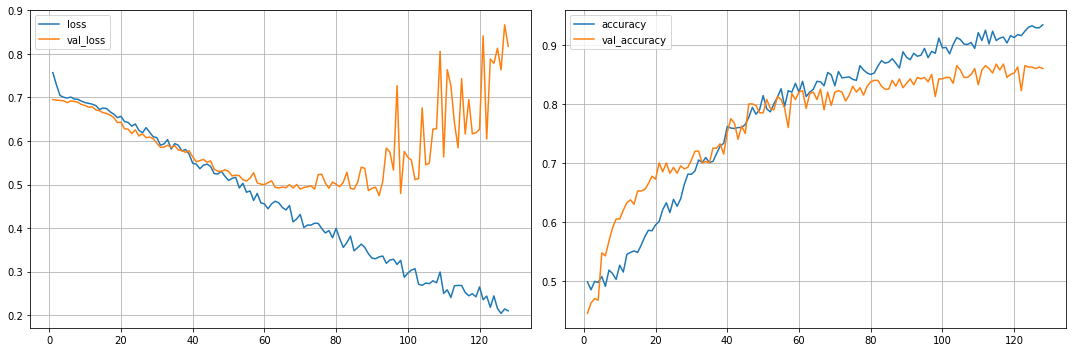

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16, 200, 200, 3)] 0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 512)           14714688  
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                69760     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0   

In [9]:
# time to start training
start_time = time.time()

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                    validation_data=(X_validation, y_validation),
                    shuffle=True,
                    callbacks=[PlotLearning(),
                               check_point])

# time at the end of training
end_time = time.time()

model_last_filename = "lstm-vgg16-b" + str(BATCH_SIZE) + "-e" + str(EPOCHS) + "-16frames-last-dropout-" + str(DROPOUT) + "-" + VERSION + ".h5"

model.summary()
model.save(model_last_filename)

# time to train
msg = display_time(end_time - start_time)
print("Training time: %s" % msg)

In [10]:
accuracy = history.history['accuracy']
max(accuracy)

0.934166669845581

In [11]:
loss = history.history['loss']
min(loss)

0.204075425863266

In [12]:
val_accuracy = history.history['val_accuracy']
max(val_accuracy)

0.8675000071525574

In [13]:
val_loss = history.history['val_loss']
min(val_loss)

0.47450610995292664

## Testing the model

In [14]:
prediction = model.predict(X_train[:1])

In [15]:
prediction

array([[0.4580991 , 0.54190093]], dtype=float32)